In [4]:
import pandas as pd

# Carregar dados
df = pd.read_csv('../data/Telemetria_de_M_ltiplas_Bombas.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Ordenar por timestamp
df = df.sort_values(by='timestamp')

# Confirmar estrutura
df.head()


,timestamp,pump_id,pressure_in,pressure_out,vibration,temperature,rpm,flow_rate,power_consumption
0,2024-01-01 00:00:00,pump_001,5.392593,9.525054,1.503521,79.396536,1826.510709,43.211838,15.256310
1000,2024-01-01 00:00:00,pump_002,5.183487,9.475274,1.532728,75.300894,1854.828625,62.994185,15.287985
2000,2024-01-01 00:00:00,pump_003,5.782701,11.422370,1.656973,80.609176,2091.113255,50.643132,14.824360
1,2024-01-01 00:15:00,pump_001,4.111160,9.786150,1.658232,75.196546,1753.947658,49.366054,15.018383
1001,2024-01-01 00:15:00,pump_002,4.948175,10.602995,1.536750,77.910674,1848.332359,53.716777,13.726220


In [5]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\pedro\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
from scipy.stats import zscore

# Selecionar uma bomba para começar 
df_pump = df[df['pump_id'] == 'pump_001'].copy()

# Escolher variáveis para detectar anomalias
cols_monitorar = ['pressure_out', 'vibration', 'temperature', 'power_consumption']

# Calcular Z-Score
for col in cols_monitorar:
    df_pump[f'z_{col}'] = zscore(df_pump[col])

# Definir anomalias onde o Z-Score absoluto for > 3
for col in cols_monitorar:
    df_pump[f'anomaly_{col}'] = df_pump[f'z_{col}'].abs() > 3

# Verificar se encontrou algo
df_pump[[f'anomaly_{col}' for col in cols_monitorar]].sum()


anomaly_pressure_out         4
anomaly_vibration            4
anomaly_temperature          0
anomaly_power_consumption    4
dtype: int64

In [ ]:
#Temperatura está estável na bomba 1, mas existem anomalias na pressão, vibração e consumo de energia
# -> Pode indicar picos anormais de pressão na saída da bomba.
#    Isso pode ocorrer por obstruções, mudanças repentinas de vazão ou falhas no controle do sistema.

# -> Vibração fora do padrão pode ser sinal de desgaste mecânico,
#    desalinhamento de eixo, folgas em componentes ou ressonância.

# -> A temperatura da bomba está dentro de uma faixa considerada estável.
#    Isso pode indicar bom controle térmico ou ausência de sobrecarga térmica.

# -> Consumo de energia acima do esperado pode sugerir que o motor está
#    sobrecarregado, compensando esforço extra ou operando com eficiência reduzida.

In [7]:
pip install scikit-learn joblib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\pedro\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
from sklearn.ensemble import IsolationForest

# Selecionar dados da pump_001
df_pump = df[df['pump_id'] == 'pump_001'].copy()

# Features para o modelo
features = ['pressure_out', 'vibration', 'temperature', 'power_consumption']
X = df_pump[features]

# Criar o modelo (estimei só 5% de contaminação por não entender do cenário)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_pump['anomaly_iforest'] = iso_forest.fit_predict(X)

# Traduzir para 1 = normal, -1 = anomalia
df_pump['anomaly_iforest'] = df_pump['anomaly_iforest'].map({1: 0, -1: 1})

# Verificar quantas foram detectadas
df_pump['anomaly_iforest'].value_counts()


anomaly_iforest
0    950
1     50
Name: count, dtype: int64

In [10]:
#observamos neste cenário 50 leituras fora do padrão, considerando o comportamento combinado das 4 variáveis
import matplotlib

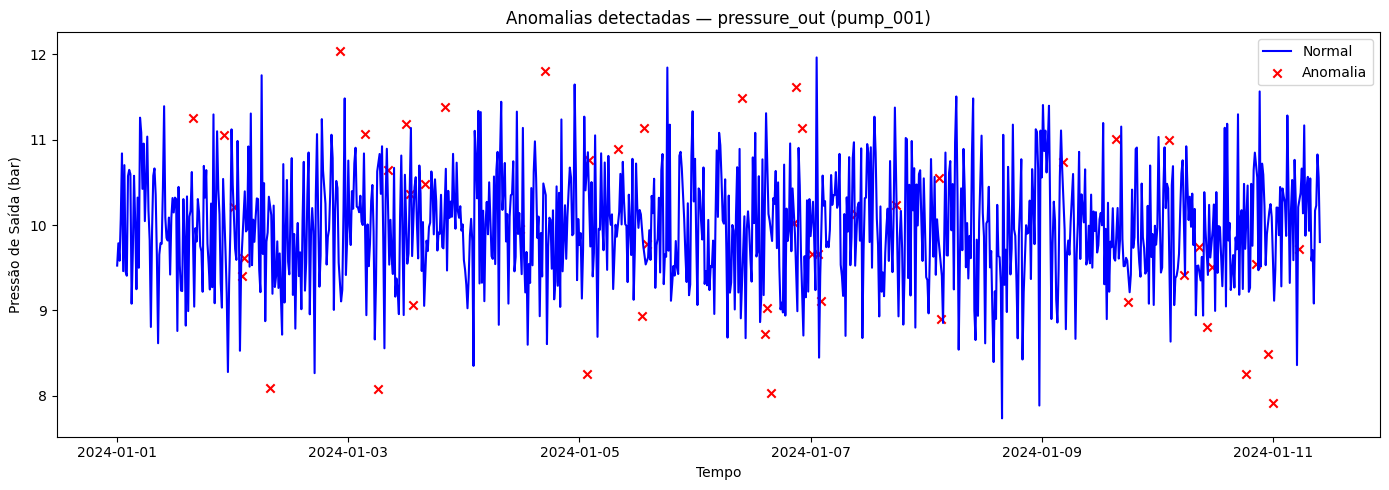

In [11]:
import matplotlib.pyplot as plt

# Separar normal e anomalia
normais = df_pump[df_pump['anomaly_iforest'] == 0]
anomalias = df_pump[df_pump['anomaly_iforest'] == 1]

# Plotar a série temporal com destaque para anomalias
plt.figure(figsize=(14, 5))
plt.plot(normais['timestamp'], normais['pressure_out'], label='Normal', color='blue')
plt.scatter(anomalias['timestamp'], anomalias['pressure_out'], label='Anomalia', color='red', marker='x')
plt.title('Anomalias detectadas — pressure_out (pump_001)')
plt.xlabel('Tempo')
plt.ylabel('Pressão de Saída (bar)')
plt.legend()
plt.tight_layout()
plt.show()


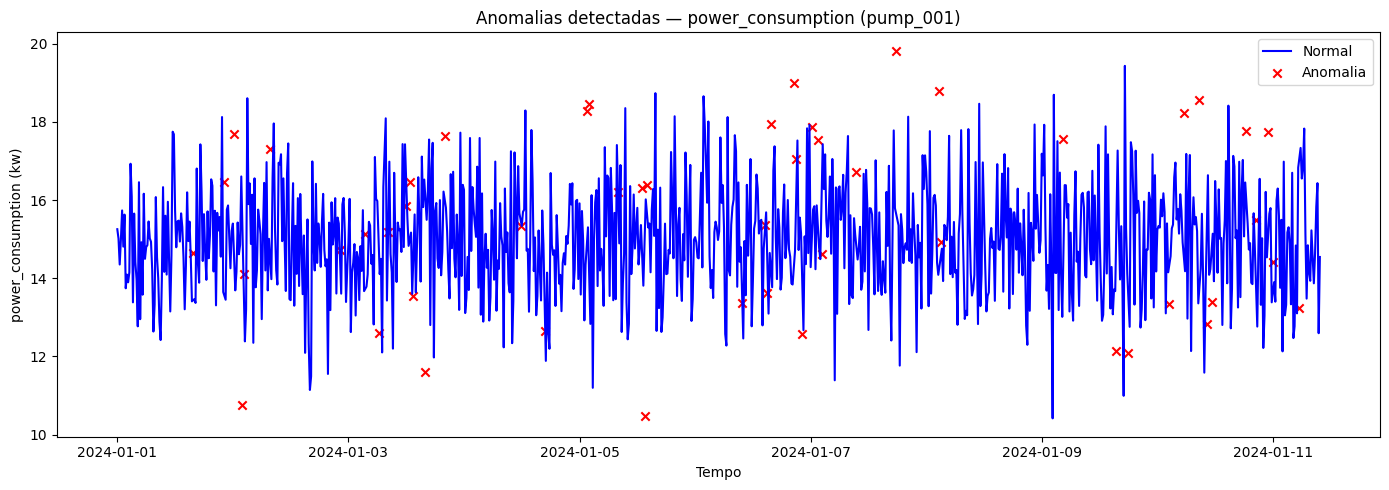

In [12]:
import matplotlib.pyplot as plt

# Separar normal e anomalia
normais = df_pump[df_pump['anomaly_iforest'] == 0]
anomalias = df_pump[df_pump['anomaly_iforest'] == 1]

# Plotar a série temporal com destaque para anomalias
plt.figure(figsize=(14, 5))
plt.plot(normais['timestamp'], normais['power_consumption'], label='Normal', color='blue')
plt.scatter(anomalias['timestamp'], anomalias['power_consumption'], label='Anomalia', color='red', marker='x')
plt.title('Anomalias detectadas — power_consumption (pump_001)')
plt.xlabel('Tempo')
plt.ylabel('power_consumption (kw)')
plt.legend()
plt.tight_layout()
plt.show()

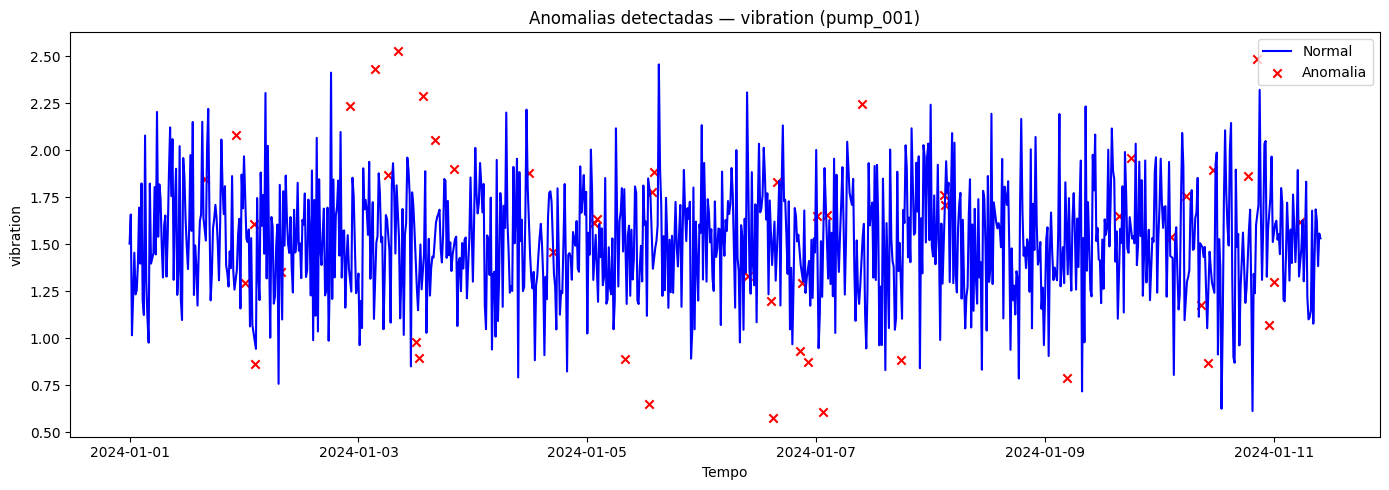

In [13]:
import matplotlib.pyplot as plt

# Separar normal e anomalia
normais = df_pump[df_pump['anomaly_iforest'] == 0]
anomalias = df_pump[df_pump['anomaly_iforest'] == 1]

# Plotar a série temporal com destaque para anomalias
plt.figure(figsize=(14, 5))
plt.plot(normais['timestamp'], normais['vibration'], label='Normal', color='blue')
plt.scatter(anomalias['timestamp'], anomalias['vibration'], label='Anomalia', color='red', marker='x')
plt.title('Anomalias detectadas — vibration (pump_001)')
plt.xlabel('Tempo')
plt.ylabel('vibration')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Como a leitura é de uma base sintetica não existe padrão, mas aqui observaríamos possíveis padrões como por exemplo uma temperatura elevada quando a vibração devido a um desgaste passou a se intensificar